In [161]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
import seaborn as sns
import empyrical
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
%matplotlib inline

# 定义参数

In [47]:
K = 20

# 函数

In [48]:
def rank_percentile(array):
    """
    返回s的最后一个元素在s中的分位值
    """
    s = pd.Series(array)
    s = s.rank(pct=True)
    return s.iloc[-1]

In [49]:
def roll(df, w):
    """
    This fucntion comes from:
    http://stackoverflow.com/questions/37486502/why-does-pandas-rolling-use-single-dimension-ndarray/37491779#37491779
    """
    df.fillna(df.mean(), inplace=True)
    roll_array = np.dstack([df.values[i:i+w, :] for i in range(len(df.index) - w + 1)]).T
    panel = pd.Panel(roll_array,
                     items=df.index[w-1:],
                     major_axis=df.columns,
                     minor_axis=pd.Index(range(w), name='roll'))
    return panel.to_frame().unstack().T.groupby(level=0)

# 读取产出数据

In [52]:
macro_df = pd.read_excel('./data/scenario.xlsx', sheetname='macro', index_col=0)

In [53]:
macro_df.tail()

,工业增加值,PMI
2018-02-28,-2.119883,50.3
2018-03-31,6.000000,51.5
2018-04-30,7.000000,51.4
2018-05-31,6.800000,51.9
2018-06-30,6.000000,51.5


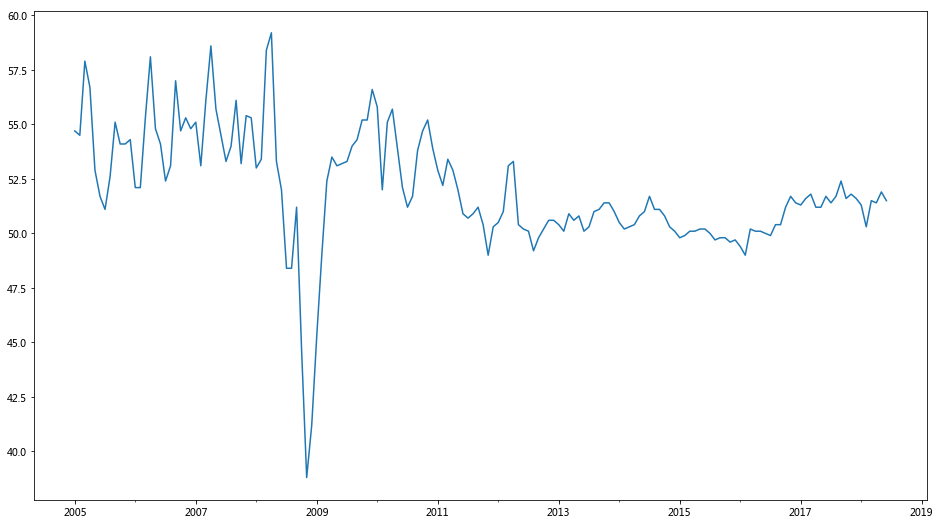

In [54]:
plt.figure(figsize=(16, 9))
macro_df['PMI'].plot()

In [55]:
inf_df = pd.read_excel('./data/scenario.xlsx', sheetname='inflation', index_col=0)

In [56]:
inf_df.shape

(330, 2)

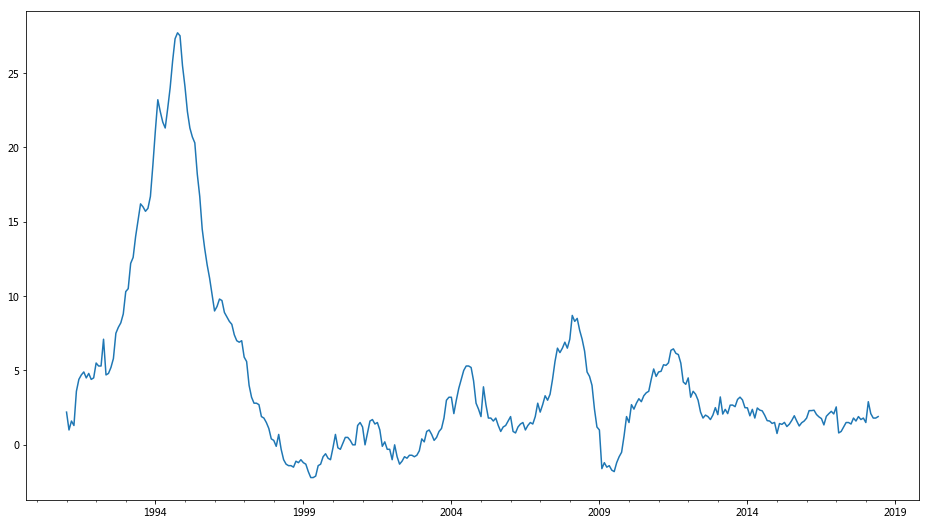

In [57]:
plt.figure(figsize=(16, 9))
inf_df['CPI'].plot()
# inf_df['PPI'].plot()

In [58]:
df = macro_df.merge(inf_df, left_index=True, right_index=True)

In [59]:
roll_df = df.copy()

In [60]:
for col in roll_df.columns:
     roll_df.loc[:, col] = roll_df[col].rolling(window=24).apply(lambda x: rank_percentile(x))

In [61]:
roll_df = roll_df.dropna()

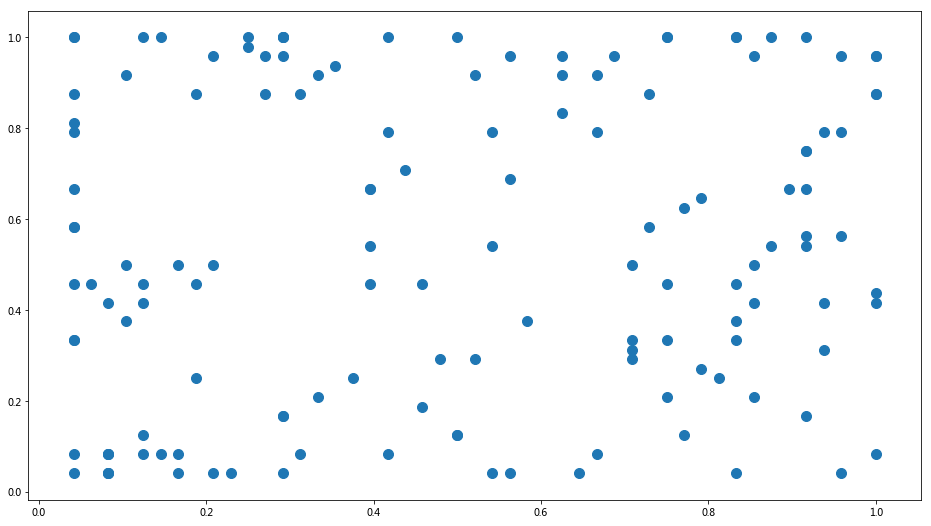

In [62]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], s=100)
# sns.lmplot('PMI', 'CPI', data=roll_df, fit_reg=False)

In [63]:
kmeans = KMeans(n_clusters=4)

In [64]:
kmeans.fit(roll_df[['PMI', 'CPI']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [65]:
roll_df.loc[:, 'label'] = kmeans.labels_

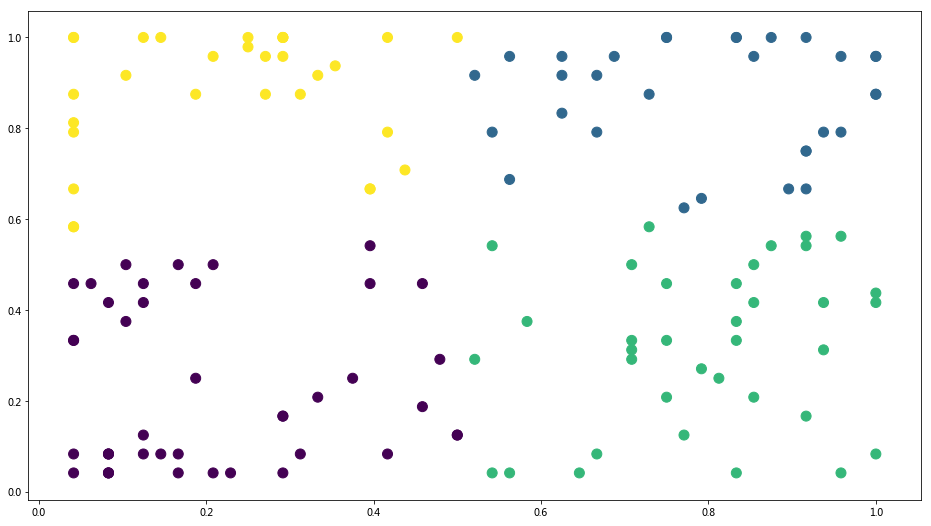

In [66]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], c=roll_df['label'], s=100)

In [67]:
kmeans.cluster_centers_

array([[0.2078373 , 0.2296627 ],
       [0.79637097, 0.86693548],
       [0.79340278, 0.31944444],
       [0.22916667, 0.87986111]])

In [68]:
# roll_df.to_excel('C:/Users/jgtzsx01/Desktop/plot.xlsx')

# 美国数据验证

In [69]:
df = pd.read_excel('./data/us.xlsx', index_col=0)

In [70]:
df.head()

,PMI,CPI
1990-01-31,47.2,5.2
1990-02-28,49.1,5.3
1990-03-31,49.9,5.2
1990-04-30,50.0,4.7
1990-05-31,49.5,4.4


In [71]:
roll_df = df.copy()

In [72]:
for col in roll_df.columns:
     roll_df.loc[:, col] = roll_df[col].rolling(window=36).apply(lambda x: rank_percentile(x))

In [73]:
roll_df['time'] = range(roll_df.shape[0])
roll_df['time'] /= roll_df.shape[0]

In [74]:
roll_df = roll_df.dropna()

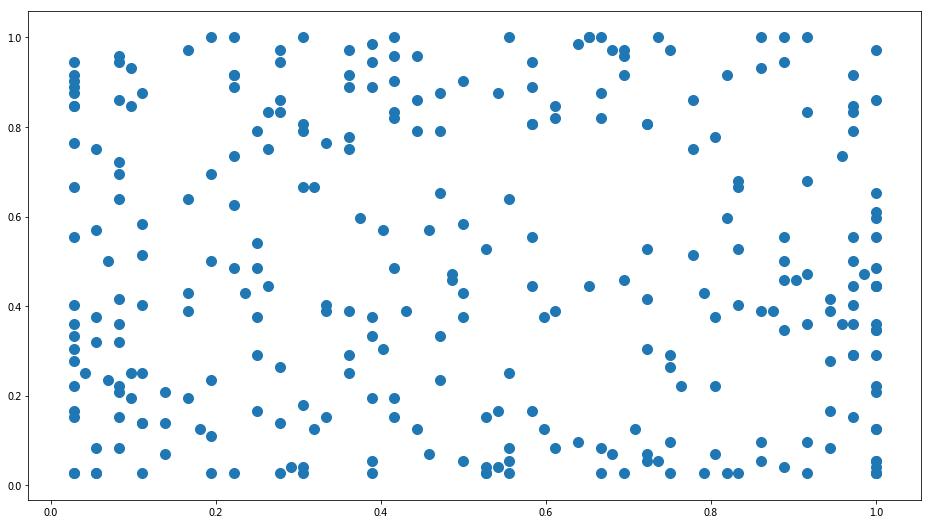

In [75]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], s=100)
# sns.lmplot('PMI', 'CPI', data=roll_df, fit_reg=False)

In [76]:
kmeans = KMeans(n_clusters=4)

In [77]:
kmeans.fit(roll_df[['PMI', 'CPI']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [78]:
roll_df.loc[:, 'label'] = kmeans.labels_

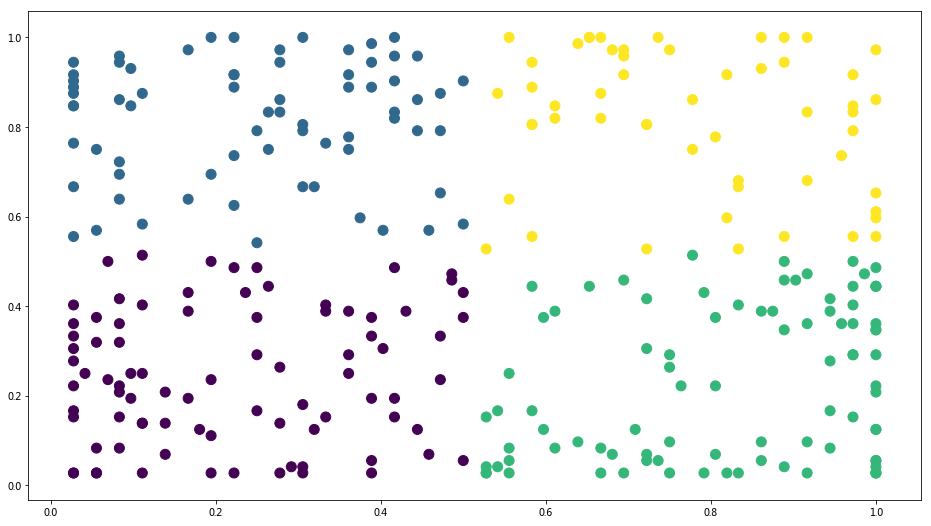

In [79]:
plt.figure(figsize=(16, 9))
plt.scatter(roll_df['PMI'], roll_df['CPI'], c=roll_df['label'], s=100)

In [80]:
kmeans.cluster_centers_

array([[0.22107843, 0.24362745],
       [0.24880952, 0.8140873 ],
       [0.81944444, 0.2282197 ],
       [0.78034979, 0.81430041]])

In [81]:
# roll_df.to_excel('C:/Users/jgtzsx01/Desktop/plot.xlsx')

# 读取股市数据

In [143]:
stock_price_df = pd.read_excel('./data/scenario.xlsx', sheetname='price', index_col=0)

# 读取债市数据

In [144]:
int_df = pd.read_excel('./data/scenario.xlsx', sheetname='interest rate', index_col=0)

# 读取商品数据

In [145]:
com_df = pd.read_excel('./data/scenario.xlsx', sheetname='price', index_col=0)

# 读取股市成交量数据

In [146]:
vol_df = pd.read_excel('./data/scenario.xlsx', sheetname='volume', index_col=0)

# 读取汇率数据

In [147]:
cur_df = pd.read_excel('./data/scenario.xlsx', sheetname='currency', index_col=0)

# 综合数据

In [222]:
df = cur_df.copy()

In [223]:
df['st vol'] = vol_df['881001.WI']

In [224]:
df['commodity'] = com_df['CCFI.WI']

In [225]:
df[['CGB1Y', 'CGB10Y']] = int_df
df['spread'] = df['CGB10Y'] - df['CGB1Y']

In [226]:
df['st price'] = stock_price_df['881001.WI']
df['st vol'] = df['st price'].rolling(243).var()

In [227]:
df['CPI'] = inf_df['CPI']

In [228]:
df['PMI'] = macro_df['PMI']

In [229]:
df = df.fillna(method='ffill')

In [230]:
df = df.dropna()

In [231]:
df.head()

,CNY,st vol,commodity,CGB1Y,CGB10Y,spread,st price,CPI,PMI
2010-10-11,6.6678,40963.283902,1438.4323,1.9370,3.4040,1.4670,2705.4341,3.6,53.8
2010-10-12,6.6734,40933.666128,1425.8605,1.9397,3.4179,1.4782,2732.1619,3.6,53.8
2010-10-13,6.6641,40918.375802,1447.0107,1.9386,3.4271,1.4885,2755.6638,3.6,53.8
2010-10-14,6.6508,40923.415585,1470.5449,1.9389,3.4275,1.4886,2741.8970,3.6,53.8
2010-10-15,6.6407,41016.154787,1474.2440,1.9337,3.4247,1.4910,2811.8662,3.6,53.8


In [232]:
df = pd.DataFrame(preprocessing.scale(df), index=df.index, columns=df.columns)

In [233]:
df.tail()

,CNY,st vol,commodity,CGB1Y,CGB10Y,spread,st price,CPI,PMI
2018-07-17,1.184520,-0.356512,-0.327246,0.095549,-0.281134,-0.516345,0.455336,-0.606353,0.904635
2018-07-18,1.337983,-0.352575,-0.339405,0.141148,-0.304034,-0.619354,0.436031,-0.606353,0.904635
2018-07-19,1.592601,-0.348392,-0.269848,0.140965,-0.372506,-0.707310,0.416260,-0.606353,0.904635
2018-07-20,1.618970,-0.344971,-0.257142,0.140965,-0.206250,-0.493028,0.471079,-0.606353,0.904635
2018-07-23,1.635830,-0.341962,-0.210382,0.141148,-0.194571,-0.478270,0.500681,-0.606353,0.904635


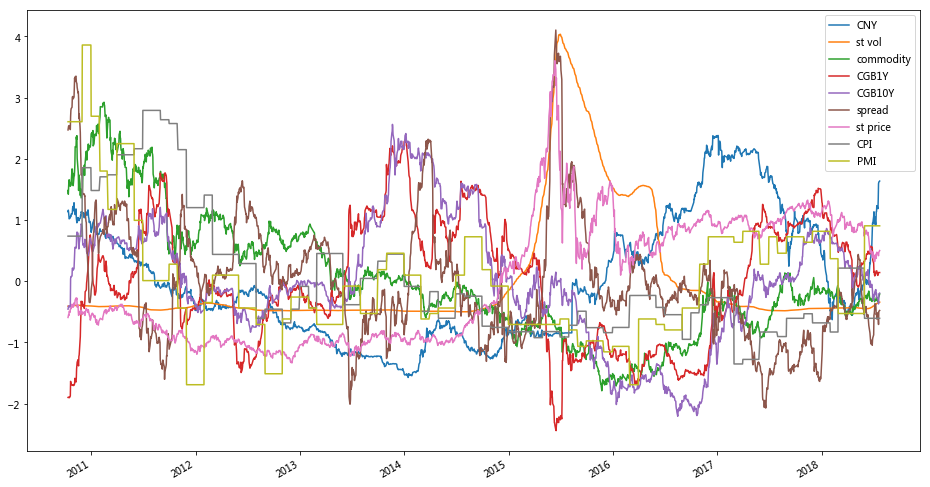

In [234]:
df.plot(figsize=(16, 9))

In [184]:
# pca = PCA(n_components=7)
# X = pca.fit_transform(df)
# pca.explained_variance_ratio_
# Xdf = pd.DataFrame(X, index=df.index, columns=range(7))

In [238]:
kmeans = KMeans(n_clusters=4)

In [239]:
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [240]:
kmeans.labels_

array([3, 3, 3, ..., 2, 2, 2])

In [241]:
df['label'] = kmeans.labels_

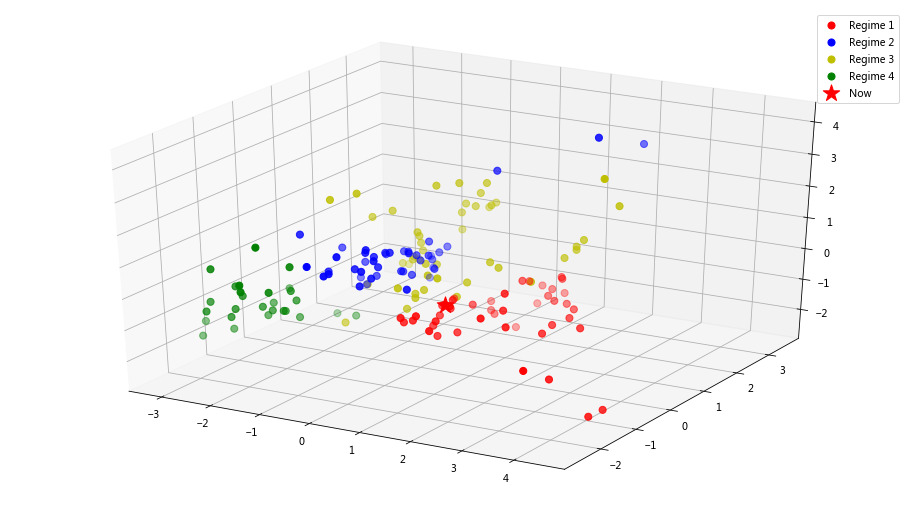

In [172]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(Xdf[0], Xdf[1], Xdf[2], c=Xdf['label'], s=50)
ax.scatter(Xdf[Xdf['label'] == 0][0], Xdf[Xdf['label'] == 0][1], Xdf[Xdf['label'] == 0][2], c='r', s=50, label='Regime 1')
ax.scatter(Xdf[Xdf['label'] == 1][0], Xdf[Xdf['label'] == 1][1], Xdf[Xdf['label'] == 1][2], c='b', s=50, label='Regime 2')
ax.scatter(Xdf[Xdf['label'] == 2][0], Xdf[Xdf['label'] == 2][1], Xdf[Xdf['label'] == 2][2], c='y', s=50, label='Regime 3')
ax.scatter(Xdf[Xdf['label'] == 3][0], Xdf[Xdf['label'] == 3][1], Xdf[Xdf['label'] == 3][2], c='g', s=50, label='Regime 4')
# ax.scatter(Xdf[Xdf['label'] == 4][0], Xdf[Xdf['label'] == 4][1], Xdf[Xdf['label'] == 4][2], c='gray', s=50, label='Regime 5')
ax.scatter(Xdf.iloc[-1][0], Xdf.iloc[-1][1], Xdf.iloc[-1][2], c='r', marker='*', s=300, label='Now')
plt.legend()